# Continuous Models Notebook Skeleton
這份 notebook 用來分析 `hospital_demand_continuous.csv` 並逐步建立新的 deterministic / SP / RO 模型。以下先建立基本架構與環境。

## 1. Set Up Notebook Environment
匯入核心函式庫、設定 pandas 顯示選項與隨機種子，確保後續分析可重複。

In [97]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# Configure deterministic behavior
SEED = 2025
rng = np.random.default_rng(SEED)

pd.set_option("display.max_rows", 10)
pd.set_option("display.precision", 3)
plt.style.use("seaborn-v0_8")

DATA_PATH = Path("hospital_demand_continuous.csv")
SUMMARY_PATH = Path("hospital_demand_continuous_summary.json")

print("Notebook environment initialized.")
print(f"Data file exists: {DATA_PATH.exists()}")

Notebook environment initialized.
Data file exists: True


## 2. Define Placeholder Functions
預先建立資料載入與模型組裝的骨架，稍後可延伸為完整流程。

In [98]:
def load_continuous_dataset(path: Path = DATA_PATH) -> pd.DataFrame:
    """Load the continuous demand scenarios into a tidy DataFrame."""
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset: {path}")
    df = pd.read_csv(path)
    print(f"Loaded {len(df)} rows from {path.name}")
    return df


def summarize_distribution(df: pd.DataFrame) -> pd.DataFrame:
    """Return aggregate demand stats grouped by hospital for quick inspection."""
    required_cols = {"hospital_id", "demand", "scenario_probability"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Dataset missing columns: {missing}")
    summary = (
        df.groupby("hospital_id")["demand"]
        .agg(["mean", "std", "min", "max", "median"])
        .round(2)
    )
    print("Computed basic demand summary (mean/std/min/max/median).")
    return summary


def prepare_core_tables(df: pd.DataFrame):
    """Create scenario, hospital, and demand pivot tables used by the models."""
    scenario_info = (
        df[
            [
                "scenario_id",
                "scenario_probability",
                "disaster_type",
                "severity_score",
                "global_severity",
            ]
        ]
        .drop_duplicates(subset="scenario_id")
        .set_index("scenario_id")
        .sort_index()
    )
    hospital_info = (
        df[["hospital_id", "hospital_name", "capacity_beds", "allocation_cost_per_unit"]]
        .drop_duplicates()
        .set_index("hospital_id")
        .sort_index()
    )
    demand_table = (
        df.pivot_table(
            index="scenario_id",
            columns="hospital_id",
            values="demand",
            aggfunc="first",
        )
        .reindex(scenario_info.index)
        .astype(float)
    )
    return scenario_info, hospital_info, demand_table


def solution_to_frame(variable_dict, index_labels, value_name):
    """Convert a {(keys): var} dictionary into a tidy DataFrame."""
    records = []
    for key, var in variable_dict.items():
        val = getattr(var, "X", var)
        if abs(val) <= 1e-6:
            continue
        key = key if isinstance(key, tuple) else (key,)
        records.append(dict(zip(index_labels, key), **{value_name: val}))
    return pd.DataFrame(records).set_index(index_labels) if records else pd.DataFrame()


def shortage_dict_from_vars(shortage_vars, scenarios, hospitals):
    """Aggregate hospital-level shortage variables into scenario totals."""
    return {
        s: float(sum(shortage_vars[s, h].X for h in hospitals))
        for s in scenarios
    }


def evaluate_static_plan(plan, demand_table, capacity):
    """Given a single allocation plan, evaluate shortages across all scenarios."""
    shortages = {}
    for scenario, row in demand_table.iterrows():
        deficit = 0.0
        for hospital, demand_value in row.items():
            available = min(plan.get(hospital, 0.0), capacity[hospital])
            deficit += max(0.0, demand_value - available)
        shortages[scenario] = deficit
    return shortages


def compute_shortage_metrics(shortage_by_scenario, scenario_prob):
    """Return expected, worst-case, and 95th percentile shortages."""
    values = list(shortage_by_scenario.values())
    probs = scenario_prob.reindex(shortage_by_scenario.keys())
    expected_shortage = float(sum(probs[s] * shortage_by_scenario[s] for s in shortage_by_scenario))
    worst_case = float(max(values))
    p95 = float(np.quantile(values, 0.95))
    return {
        "expected_shortage": expected_shortage,
        "worst_case_shortage": worst_case,
        "p95_shortage": p95,
    }


def build_placeholder_models(df: pd.DataFrame) -> None:
    """Retained for backward compatibility; replaced by full models below."""
    hospitals = df["hospital_id"].nunique()
    scenarios = df["scenario_id"].nunique()
    print(
        "Models below will operate on:"
        f" {hospitals} hospitals × {scenarios} continuous scenarios"
    )

## 3. Continuous Scenario Overview
透過載入 dataset、檢查機率總和與醫院基本資訊，確認後續模型的輸入品質。

In [99]:
df_all = load_continuous_dataset()
scenario_info, hospital_info, demand_table = prepare_core_tables(df_all)
scenario_prob = scenario_info["scenario_probability"]
hospitals = list(hospital_info.index)
scenarios = list(scenario_info.index)

print(
    "Scenarios:"
    f" {len(scenarios)} | Hospitals: {len(hospitals)} | Probability mass: {scenario_prob.sum():.4f}"
)
display(df_all.head())

display(hospital_info)
print("Scenario severity preview:")
display(scenario_info.head())

Loaded 3000 rows from hospital_demand_continuous.csv
Scenarios: 1000 | Hospitals: 3 | Probability mass: 1.0000


,scenario_id,scenario_probability,disaster_type,severity_score,hospital_id,hospital_name,capacity_beds,allocation_cost_per_unit,global_severity,regional_component,idiosyncratic_component,demand,shortage_penalty_per_unit
0,CSBASE,3.500e-01,no_event,0.000,H1,Central Hospital,250,2.0,0.000,0.000,0.000,7.00,8.0
1,CSBASE,3.500e-01,no_event,0.000,H2,North Clinic,180,2.2,0.000,0.000,0.000,5.25,8.0
2,CSBASE,3.500e-01,no_event,0.000,H3,South Medical Center,150,1.8,0.000,0.000,0.000,4.20,8.0
3,CS0000,3.324e-04,earthquake,2.612,H1,Central Hospital,250,2.0,12.629,-13.457,-11.720,7.45,8.0
4,CS0000,3.324e-04,earthquake,2.612,H2,North Clinic,180,2.2,12.629,2.331,1.151,29.22,8.0


,hospital_name,capacity_beds,allocation_cost_per_unit
hospital_id,,,
H1,Central Hospital,250,2.0
H2,North Clinic,180,2.2
H3,South Medical Center,150,1.8


Scenario severity preview:


,scenario_probability,disaster_type,severity_score,global_severity
scenario_id,,,,
CS0000,3.324e-04,earthquake,2.612,12.629
CS0001,7.741e-04,seasonal_flu,2.028,6.598
CS0002,4.949e-04,coastal_storm,2.333,9.314
CS0003,3.610e-04,earthquake,2.837,16.067
CS0004,7.774e-04,seasonal_flu,2.036,6.663


### 3.1 基本統計

In [100]:
hospital_summary = summarize_distribution(df_all)
severity_stats = scenario_info["severity_score"].describe(percentiles=[0.5, 0.9, 0.99])
prob_by_disaster = (
    scenario_info.groupby("disaster_type")["scenario_probability"].sum().sort_values(ascending=False)
)

print("Demand summary by hospital:")
display(hospital_summary)

print("Severity score distribution (per scenario):")
display(severity_stats.to_frame(name="severity_stats"))

print("Probability mass by disaster type:")
display(prob_by_disaster.to_frame(name="probability"))

Computed basic demand summary (mean/std/min/max/median).
Demand summary by hospital:


,mean,std,min,max,median
hospital_id,,,,,
H1,33.14,13.58,0.0,96.42,31.42
H2,26.04,12.30,0.0,74.97,24.99
H3,21.41,10.97,0.0,60.82,20.70


Severity score distribution (per scenario):


,severity_stats
count,1000.000
mean,2.560
std,0.455
min,0.000
50%,2.472
90%,3.229
99%,3.702
max,3.986


Probability mass by disaster type:


,probability
disaster_type,
seasonal_flu,0.407
no_event,0.350
coastal_storm,0.133
pandemic_wave,0.058
earthquake,0.052


### 3.2 分佈與相關性

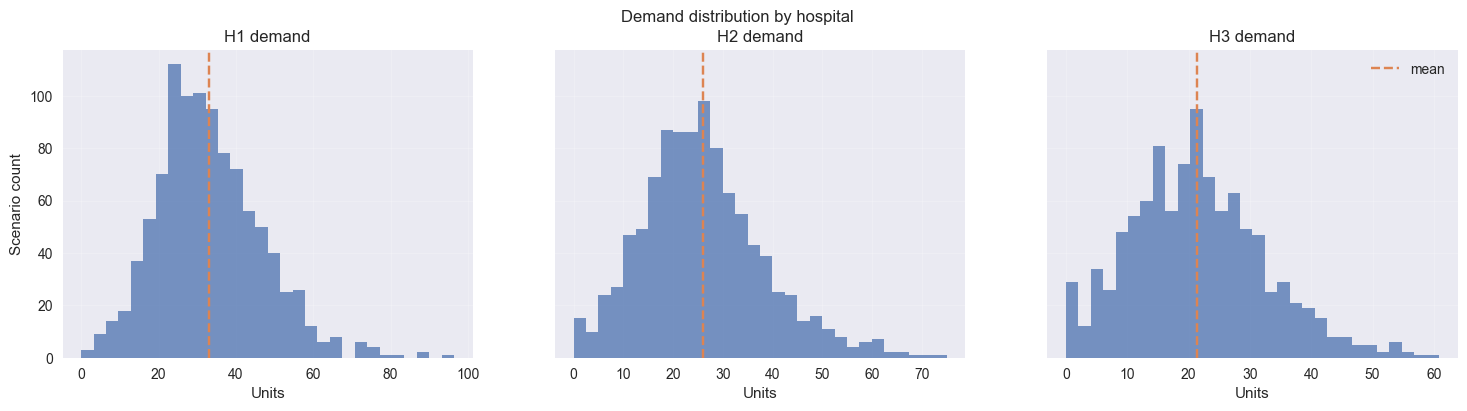

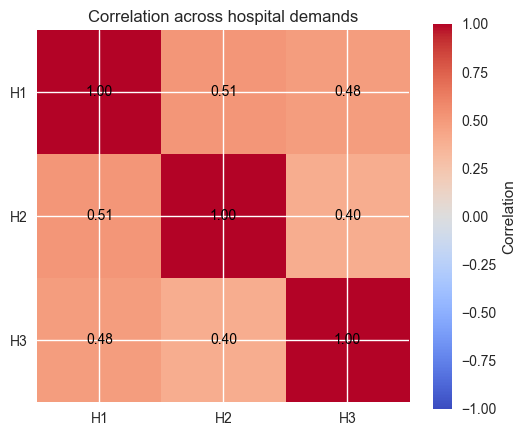

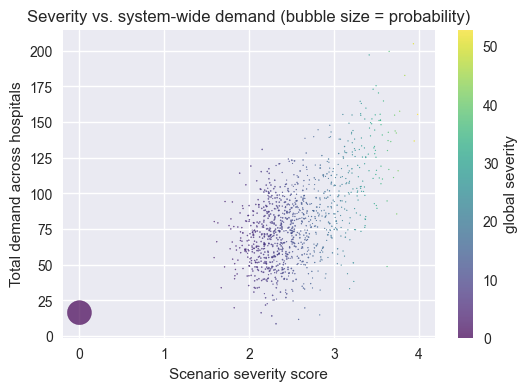

In [101]:
fig, axes = plt.subplots(1, len(hospitals), figsize=(18, 4), sharey=True)
for idx, hospital in enumerate(hospitals):
    series = demand_table[hospital]
    axes[idx].hist(series, bins=30, color="#4C72B0", alpha=0.75)
    axes[idx].axvline(series.mean(), color="#DD8452", linestyle="--", label="mean")
    axes[idx].set_title(f"{hospital} demand")
    axes[idx].set_xlabel("Units")
    axes[idx].grid(alpha=0.2)
axes[0].set_ylabel("Scenario count")
axes[-1].legend(loc="upper right")
plt.suptitle("Demand distribution by hospital")
plt.show()

corr = demand_table[hospitals].corr()
plt.figure(figsize=(6, 5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(range(len(hospitals)), hospitals)
plt.yticks(range(len(hospitals)), hospitals)
plt.colorbar(label="Correlation")
plt.title("Correlation across hospital demands")
for i in range(len(hospitals)):
    for j in range(len(hospitals)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", color="black")
plt.show()

total_demand = demand_table.sum(axis=1)
plt.figure(figsize=(6, 4))
prob_scaled = 400 * scenario_prob.loc[total_demand.index]
prob_scaled = prob_scaled / prob_scaled.max() * 300  # keep bubble sizes readable
scatter = plt.scatter(
    scenario_info.loc[total_demand.index, "severity_score"],
    total_demand,
    c=scenario_info.loc[total_demand.index, "global_severity"],
    s=prob_scaled,
    cmap="viridis",
    alpha=0.7,
)
plt.colorbar(scatter, label="global severity")
plt.xlabel("Scenario severity score")
plt.ylabel("Total demand across hospitals")
plt.title("Severity vs. system-wide demand (bubble size = probability)")
plt.show()

## 4. Modeling Inputs
整理需求 pivot、容量與成本參數，並確認這些假設與離散版本一致。

In [102]:
TOTAL_PREPOSITION_STOCK = 220
SURGE_STOCK = 120
SURGE_COST_MULTIPLIER = 1.35
SHORTAGE_PENALTY = float(df_all["shortage_penalty_per_unit"].iloc[0])

allocation_cost = hospital_info["allocation_cost_per_unit"].to_dict()
capacity = hospital_info["capacity_beds"].to_dict()
scenario_prob = scenario_prob  # keep name explicit for clarity

expected_demand = demand_table.mul(scenario_prob, axis=0).sum()
incremental_quantiles = demand_table.quantile([0.9, 0.95, 0.99]).T

model_inputs = pd.concat(
    [
        hospital_info[["hospital_name", "capacity_beds", "allocation_cost_per_unit"]],
        expected_demand.rename("expected_demand"),
        incremental_quantiles,
    ],
    axis=1,
).rename(columns={0.9: "q90", 0.95: "q95", 0.99: "q99"})

print("Shared parameters:")
print(
    f"TOTAL_PREPOSITION_STOCK={TOTAL_PREPOSITION_STOCK}, SURGE_STOCK={SURGE_STOCK}, "
    f"SHORTAGE_PENALTY={SHORTAGE_PENALTY}"
)

display(model_inputs.round(2))

Shared parameters:
TOTAL_PREPOSITION_STOCK=220, SURGE_STOCK=120, SHORTAGE_PENALTY=8.0


,hospital_name,capacity_beds,allocation_cost_per_unit,expected_demand,q90,q95,q99
hospital_id,,,,,,,
H1,Central Hospital,250,2.0,23.21,51.11,56.60,73.31
H2,North Clinic,180,2.2,18.09,42.16,48.39,60.85
H3,South Medical Center,150,1.8,14.81,35.90,40.68,52.13


## 5. Optimization Models
以下依序建立 baseline (perfect foresight)、two-stage SP、deterministic、box-robust 與 ellipsoidal-robust 模型，並儲存比較所需的指標。

In [103]:
try:
    import gurobipy as gp
    from gurobipy import GRB
except ImportError as exc:
    raise ImportError(
        "This notebook requires gurobipy. Verify the ORA conda environment has Gurobi and a valid license."
    ) from exc

results = []  # store evaluation dictionaries for the comparison table later
print("Gurobi loaded successfully.")

Gurobi loaded successfully.


### 5.1 Perfect-foresight upper bound (benchmark)

In [104]:
pf_model = gp.Model("pf_upper_bound")
alloc_pf = pf_model.addVars(scenarios, hospitals, name="alloc", lb=0)
shortage_pf = pf_model.addVars(scenarios, hospitals, name="shortage", lb=0)

for s in scenarios:
    pf_model.addConstr(
        gp.quicksum(alloc_pf[s, h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK,
        name=f"total_stock_{s}",
    )
    for h in hospitals:
        pf_model.addConstr(alloc_pf[s, h] <= capacity[h], name=f"cap_{s}_{h}")
        pf_model.addConstr(
            alloc_pf[s, h] + shortage_pf[s, h] == demand_table.loc[s, h],
            name=f"balance_{s}_{h}",
        )

pf_model.setObjective(
    gp.quicksum(
        scenario_prob[s]
        * gp.quicksum(
            allocation_cost[h] * alloc_pf[s, h] + SHORTAGE_PENALTY * shortage_pf[s, h]
            for h in hospitals
        )
        for s in scenarios
    ),
    GRB.MINIMIZE,
)

pf_model.Params.OutputFlag = 0
pf_model.optimize()
print(f"Perfect-foresight optimal objective: {pf_model.ObjVal:,.2f}")

pf_alloc_df = solution_to_frame(alloc_pf, ["scenario_id", "hospital_id"], "resources")
pf_shortage_df = solution_to_frame(shortage_pf, ["scenario_id", "hospital_id"], "shortage")
print("Scenario-dependent allocation preview:")
display(pf_alloc_df.head())

pf_shortage_by_scenario = shortage_dict_from_vars(shortage_pf, scenarios, hospitals)
pf_metrics = compute_shortage_metrics(pf_shortage_by_scenario, scenario_prob)
results.append(
    {
        "model": "Perfect-foresight UB",
        "objective": pf_model.ObjVal,
        **pf_metrics,
    }
)

Perfect-foresight optimal objective: 112.87
Scenario-dependent allocation preview:


resources
scenario_id hospital_id           
CS0000      H1                7.45
            H2               29.22
            H3               13.55
CS0001      H1               28.08
            H2               20.22

### 5.2 Two-stage stochastic programming (pre-position + surge)

In [105]:
sp_model = gp.Model("two_stage_sp")
preposition = sp_model.addVars(hospitals, name="pre", lb=0)
surge = sp_model.addVars(scenarios, hospitals, name="surge", lb=0)
shortage_sp = sp_model.addVars(scenarios, hospitals, name="shortage", lb=0)

sp_model.addConstr(
    gp.quicksum(preposition[h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK,
    name="preposition_budget",
)
for h in hospitals:
    sp_model.addConstr(preposition[h] <= capacity[h], name=f"pre_cap_{h}")

for s in scenarios:
    sp_model.addConstr(
        gp.quicksum(surge[s, h] for h in hospitals) <= SURGE_STOCK,
        name=f"surge_pool_{s}",
    )
    for h in hospitals:
        sp_model.addConstr(preposition[h] + surge[s, h] <= capacity[h], name=f"cap_{s}_{h}")
        sp_model.addConstr(
            preposition[h] + surge[s, h] + shortage_sp[s, h] == demand_table.loc[s, h],
            name=f"balance_{s}_{h}",
        )

first_stage_cost = gp.quicksum(allocation_cost[h] * preposition[h] for h in hospitals)
recourse_cost = gp.quicksum(
    scenario_prob[s]
    * gp.quicksum(
        SURGE_COST_MULTIPLIER * allocation_cost[h] * surge[s, h]
        + SHORTAGE_PENALTY * shortage_sp[s, h]
        for h in hospitals
    )
    for s in scenarios
)

sp_model.setObjective(first_stage_cost + recourse_cost, GRB.MINIMIZE)
sp_model.Params.OutputFlag = 0
sp_model.optimize()
print(f"Two-stage SP optimal objective: {sp_model.ObjVal:,.2f}")

preposition_df = solution_to_frame(preposition, ["hospital_id"], "preposition")
display(preposition_df)

surge_df = solution_to_frame(surge, ["scenario_id", "hospital_id"], "surge")
print("Top surge deployments (units):")
display(surge_df.sort_values("surge", ascending=False).head(10))

shortage_sp_df = solution_to_frame(shortage_sp, ["scenario_id", "hospital_id"], "shortage")
print("Largest residual shortages (units):")
display(shortage_sp_df.sort_values("shortage", ascending=False).head(10))

sp_shortage_by_scenario = shortage_dict_from_vars(shortage_sp, scenarios, hospitals)
sp_metrics = compute_shortage_metrics(sp_shortage_by_scenario, scenario_prob)
results.append(
    {
        "model": "Two-stage SP",
        "objective": sp_model.ObjVal,
        **sp_metrics,
    }
)

Two-stage SP optimal objective: 156.94


""


Top surge deployments (units):


,,surge
scenario_id,hospital_id,
CS0529,H1,87.79
CS0462,H1,82.79
CS0149,H1,75.81
CS0212,H1,75.56
CS0591,H1,75.53
CS0094,H1,75.26
CS0543,H1,74.44
CS0824,H1,73.92
CS0774,H1,73.90


Largest residual shortages (units):


,,shortage
scenario_id,hospital_id,
CS0543,H2,74.97
CS0774,H2,66.24
CS0636,H2,60.76
CS0043,H2,55.44
CS0031,H2,55.42
CS0447,H2,52.98
CS0857,H2,47.70
CS0907,H2,44.52
CS0462,H2,43.02


### 5.3 Deterministic expected-value plan

In [106]:
det_model = gp.Model("det_expected")
det_alloc = det_model.addVars(hospitals, name="alloc", lb=0)
det_shortage = det_model.addVars(hospitals, name="shortage", lb=0)

det_model.addConstr(
    gp.quicksum(det_alloc[h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK,
    name="stock_limit",
)
for h in hospitals:
    det_model.addConstr(det_alloc[h] <= capacity[h], name=f"cap_{h}")
    det_model.addConstr(
        det_alloc[h] + det_shortage[h] == expected_demand[h],
        name=f"balance_{h}",
    )

det_model.setObjective(
    gp.quicksum(
        allocation_cost[h] * det_alloc[h] + SHORTAGE_PENALTY * det_shortage[h]
        for h in hospitals
    ),
    GRB.MINIMIZE,
)

det_model.Params.OutputFlag = 0
det_model.optimize()
print(f"Deterministic plan objective: {det_model.ObjVal:,.2f}")

det_alloc_df = solution_to_frame(det_alloc, ["hospital_id"], "allocation")
display(det_alloc_df)

det_plan = {h: det_alloc[h].X for h in hospitals}
det_shortage_by_scenario = evaluate_static_plan(det_plan, demand_table, capacity)
det_metrics = compute_shortage_metrics(det_shortage_by_scenario, scenario_prob)
results.append(
    {
        "model": "Deterministic expected",
        "objective": det_model.ObjVal,
        **det_metrics,
    }
)

Deterministic plan objective: 112.87


,allocation
hospital_id,
H1,23.210
H2,18.092
H3,14.806


### 5.4 Box-robust quantile coverage

In [107]:
BOX_QUANTILE = 0.975
box_target = demand_table.quantile(BOX_QUANTILE)

box_model = gp.Model("box_robust")
box_alloc = box_model.addVars(hospitals, name="alloc", lb=0)
box_shortage = box_model.addVars(hospitals, name="shortage", lb=0)

box_model.addConstr(
    gp.quicksum(box_alloc[h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK,
    name="stock_limit",
)
for h in hospitals:
    box_model.addConstr(box_alloc[h] <= capacity[h], name=f"cap_{h}")
    box_model.addConstr(
        box_alloc[h] + box_shortage[h] >= box_target[h],
        name=f"quantile_cover_{h}",
    )

box_model.setObjective(
    gp.quicksum(allocation_cost[h] * box_alloc[h] for h in hospitals)
    + SHORTAGE_PENALTY * gp.quicksum(box_shortage[h] for h in hospitals),
    GRB.MINIMIZE,
)

box_model.Params.OutputFlag = 0
box_model.optimize()
print(
    f"Box-robust plan objective: {box_model.ObjVal:,.2f} (quantile={BOX_QUANTILE:.3f})"
)

box_alloc_df = solution_to_frame(box_alloc, ["hospital_id"], "allocation")
display(box_alloc_df)

box_plan = {h: box_alloc[h].X for h in hospitals}
box_shortage_by_scenario = evaluate_static_plan(box_plan, demand_table, capacity)
box_metrics = compute_shortage_metrics(box_shortage_by_scenario, scenario_prob)
results.append(
    {
        "model": f"Box robust (q{int(BOX_QUANTILE*1000)/1000:.3f})",
        "objective": box_model.ObjVal,
        **box_metrics,
    }
)

Box-robust plan objective: 322.97 (quantile=0.975)


,allocation
hospital_id,
H1,62.071
H2,53.203
H3,45.433


### 5.5 Ellipsoidal stress-test robust plan

In [108]:
def build_ellipsoid_stress_points(demand_table, hospitals, radius=1.5):
    """Create stress scenarios along covariance eigen-directions to approximate an ellipsoid."""
    mean_vec = demand_table[hospitals].mean().values
    cov = demand_table[hospitals].cov().values
    eigvals, eigvecs = np.linalg.eigh(cov)
    stress = {"mean": mean_vec}
    for idx, eigval in enumerate(eigvals):
        if eigval <= 0:
            continue
        direction = np.sqrt(eigval) * eigvecs[:, idx]
        for sign, label in [(1, "plus"), (-1, "minus")]:
            vec = mean_vec + sign * radius * direction
            stress[f"eig{idx}_{label}"] = np.clip(vec, 0, None)
    stress_df = pd.DataFrame(stress, index=hospitals).T
    return stress_df

ELLIPSOID_RADIUS = 1.8
stress_df = build_ellipsoid_stress_points(demand_table, hospitals, radius=ELLIPSOID_RADIUS)
print("Ellipsoidal stress scenarios (rows) in units:")
display(stress_df)

stress_ids = list(stress_df.index)
ell_model = gp.Model("ellipsoid_robust")
ell_alloc = ell_model.addVars(hospitals, name="alloc", lb=0)
ell_shortage = ell_model.addVars(stress_ids, hospitals, name="shortage", lb=0)
ell_worst = ell_model.addVar(name="worst_shortage", lb=0)

ell_model.addConstr(
    gp.quicksum(ell_alloc[h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK,
    name="stock_limit",
)
for h in hospitals:
    ell_model.addConstr(ell_alloc[h] <= capacity[h], name=f"cap_{h}")

for s in stress_ids:
    scenario_shortage = gp.quicksum(ell_shortage[s, h] for h in hospitals)
    ell_model.addConstr(scenario_shortage <= ell_worst, name=f"worst_{s}")
    for h in hospitals:
        ell_model.addConstr(
            ell_alloc[h] + ell_shortage[s, h] >= float(stress_df.loc[s, h]),
            name=f"cover_{s}_{h}",
        )

ell_model.setObjective(
    gp.quicksum(allocation_cost[h] * ell_alloc[h] for h in hospitals)
    + SHORTAGE_PENALTY * ell_worst,
    GRB.MINIMIZE,
)

ell_model.Params.OutputFlag = 0
ell_model.optimize()
print(f"Ellipsoidal robust objective: {ell_model.ObjVal:,.2f} (radius={ELLIPSOID_RADIUS})")

ell_alloc_df = solution_to_frame(ell_alloc, ["hospital_id"], "allocation")
display(ell_alloc_df)

ell_plan = {h: ell_alloc[h].X for h in hospitals}
ell_shortage_by_scenario = evaluate_static_plan(ell_plan, demand_table, capacity)
ell_metrics = compute_shortage_metrics(ell_shortage_by_scenario, scenario_prob)
results.append(
    {
        "model": f"Ellipsoid robust (r={ELLIPSOID_RADIUS})",
        "objective": ell_model.ObjVal,
        **ell_metrics,
    }
)

Ellipsoidal stress scenarios (rows) in units:


,H1,H2,H3
mean,33.135,26.036,21.409
eig0_plus,23.779,27.946,33.584
eig0_minus,42.492,24.126,9.234
eig1_plus,39.485,12.645,28.390
eig1_minus,26.785,39.426,14.428
eig2_plus,11.468,8.513,7.507
eig2_minus,54.802,43.559,35.311


Ellipsoidal robust objective: 268.99 (radius=1.8)


,allocation
hospital_id,
H1,54.802
H2,43.559
H3,35.311


## 6. Scenario-level evaluation & visualization
將所有模型在 1000 個連續情境上做比較，並視覺化風險/成本 trade-off。

Model performance summary (lower is better):


,objective,expected_shortage,worst_case_shortage,p95_shortage
model,,,,
Perfect-foresight UB,112.87,0.00,0.00,0.00
Box robust (q0.975),322.97,0.27,44.14,2.52
Two-stage SP,156.94,0.91,84.85,17.03
Ellipsoid robust (r=1.8),268.99,0.92,71.18,13.25
Deterministic expected,112.87,16.99,148.74,80.92


Scenario-level shortage comparison (first 10 rows):


,probability,PF_shortage,SP_shortage,Deterministic_shortage,Box_shortage,Ellipsoid_shortage
CS0000,3.324e-04,0.0,0.0,11.128,0.0,0.000
CS0001,7.741e-04,0.0,0.0,6.998,0.0,0.000
CS0002,4.949e-04,0.0,0.0,8.558,0.0,0.000
CS0003,3.610e-04,0.0,0.0,40.208,0.0,0.651
CS0004,7.774e-04,0.0,0.0,0.000,0.0,0.000
CS0005,8.923e-04,0.0,0.0,33.712,0.0,0.000
CS0006,8.515e-04,0.0,0.0,3.898,0.0,0.000
CS0007,9.752e-04,0.0,0.0,38.612,0.0,0.000
CS0008,5.908e-04,0.0,0.0,17.214,0.0,0.000
CS0009,8.883e-04,0.0,0.0,15.128,0.0,0.000


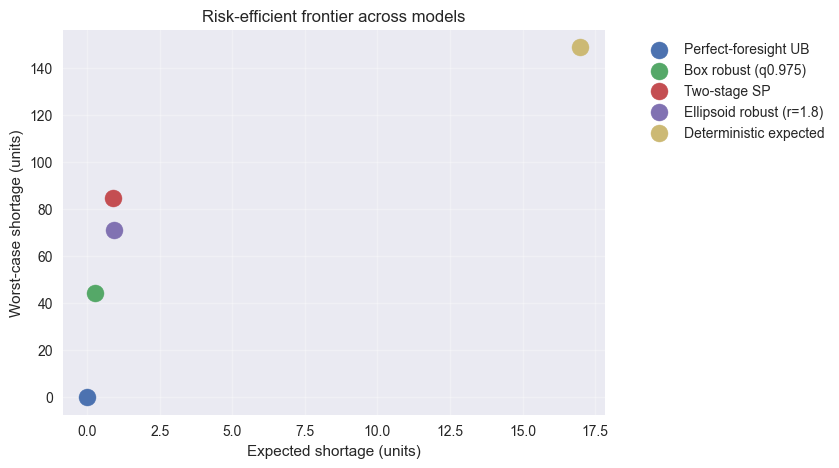

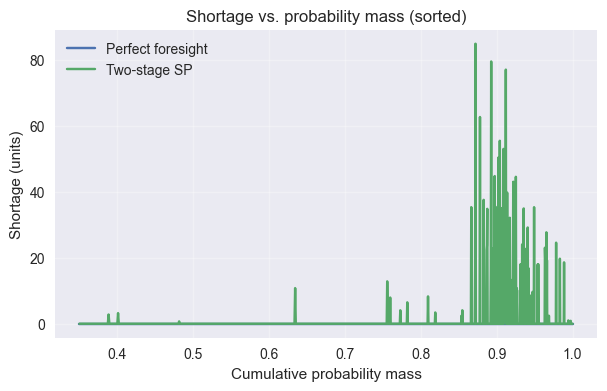

In [109]:
results_table = pd.DataFrame(results).set_index("model").sort_values("expected_shortage")
print("Model performance summary (lower is better):")
display(results_table.round(2))

scenario_shortage_compare = pd.DataFrame(
    {
        "probability": scenario_prob,
        "PF_shortage": pd.Series(pf_shortage_by_scenario),
        "SP_shortage": pd.Series(sp_shortage_by_scenario),
        "Deterministic_shortage": pd.Series(det_shortage_by_scenario),
        "Box_shortage": pd.Series(box_shortage_by_scenario),
        "Ellipsoid_shortage": pd.Series(ell_shortage_by_scenario),
    }
).fillna(0)

print("Scenario-level shortage comparison (first 10 rows):")
display(scenario_shortage_compare.head(10))

plt.figure(figsize=(7, 5))
for model_name, row in results_table.iterrows():
    plt.scatter(
        row["expected_shortage"],
        row["worst_case_shortage"],
        s=150,
        label=model_name,
    )
plt.xlabel("Expected shortage (units)")
plt.ylabel("Worst-case shortage (units)")
plt.title("Risk-efficient frontier across models")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(
    scenario_shortage_compare.sort_values("probability", ascending=False)["probability"].cumsum().values,
    scenario_shortage_compare.sort_values("probability", ascending=False)["PF_shortage"].values,
    label="Perfect foresight",
)
plt.plot(
    scenario_shortage_compare.sort_values("probability", ascending=False)["probability"].cumsum().values,
    scenario_shortage_compare.sort_values("probability", ascending=False)["SP_shortage"].values,
    label="Two-stage SP",
)
plt.xlabel("Cumulative probability mass")
plt.ylabel("Shortage (units)")
plt.title("Shortage vs. probability mass (sorted)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 6.1 Shortage contribution sanity check
為確認 box-robust 計畫的期望缺口是否合理，下方計算每個情境對期望缺口的貢獻，並檢視嚴重程度分組後的貢獻比例。

Box-robust expected shortage (recomputed): 0.274 units
Matches results table: 0.274 units

Top 5 scenario contributions to box expected shortage:


,expected_shortage_contrib
CS0031,0.022
CS0774,0.018
CS0543,0.016
CS0529,0.012
CS0636,0.011


Baseline scenario CSBASE => probability: 0.350, shortage: 0.000

Expected shortage contribution by severity bucket (box model):


C:\Users\jyL\AppData\Local\Temp\ipykernel_4816\499357165.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis.groupby("severity_bucket")["box_expected_contrib"].sum()


,expected_shortage_contrib,share
severity_bucket,,
"(-0.001, 2.472]",4.974e-04,0.002
"(2.472, 3.229]",4.724e-02,0.172
"(3.229, 3.702]",1.699e-01,0.619
"(3.702, 3.986]",5.662e-02,0.206


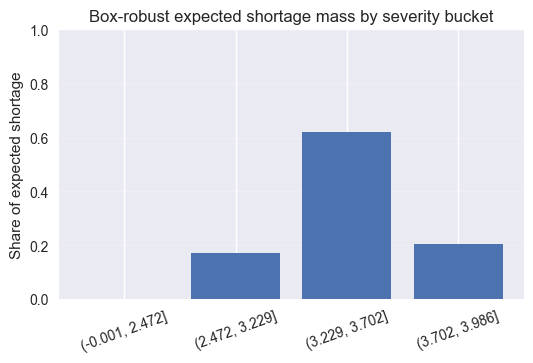

In [111]:
analysis = scenario_shortage_compare.join(scenario_info[["severity_score"]]).copy()
analysis["box_expected_contrib"] = analysis["probability"] * analysis["Box_shortage"]
analysis["sp_expected_contrib"] = analysis["probability"] * analysis["SP_shortage"]
analysis["pf_expected_contrib"] = analysis["probability"] * analysis["PF_shortage"]

box_expected = analysis["box_expected_contrib"].sum()
print(f"Box-robust expected shortage (recomputed): {box_expected:.3f} units")
if "Box robust (q0.975)" in results_table.index:
    print(
        "Matches results table:"
        f" {results_table.loc['Box robust (q0.975)', 'expected_shortage']:.3f} units"
    )

print("\nTop 5 scenario contributions to box expected shortage:")
display(
    analysis["box_expected_contrib"]
    .nlargest(5)
    .to_frame("expected_shortage_contrib")
)

if "CSBASE" in analysis.index:
    print(
        "Baseline scenario CSBASE => probability:"
        f" {analysis.loc['CSBASE', 'probability']:.3f},"
        f" shortage: {analysis.loc['CSBASE', 'Box_shortage']:.3f}"
    )

try:
    analysis["severity_bucket"] = pd.qcut(
        analysis["severity_score"],
        q=[0.0, 0.5, 0.9, 0.99, 1.0],
        duplicates="drop",
    )
except ValueError:
    analysis["severity_bucket"] = pd.cut(
        analysis["severity_score"], bins=4, include_lowest=True
    )

bucket_summary = (
    analysis.groupby("severity_bucket")["box_expected_contrib"].sum()
    .to_frame("expected_shortage_contrib")
)
bucket_summary["share"] = bucket_summary["expected_shortage_contrib"] / box_expected
print("\nExpected shortage contribution by severity bucket (box model):")
display(bucket_summary)

plt.figure(figsize=(6, 3.5))
plt.bar(
    bucket_summary.index.astype(str),
    bucket_summary["share"],
    color="#4C72B0",
)
plt.ylabel("Share of expected shortage")
plt.title("Box-robust expected shortage mass by severity bucket")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.grid(alpha=0.2, axis="y")
plt.show()

## 3. Execute Verification Cell
快速執行上述 placeholder，確認載入、摘要與模型骨架皆可正常運作。

In [110]:
if DATA_PATH.exists():
    df_preview = load_continuous_dataset()
    summary_preview = summarize_distribution(df_preview)
    display(summary_preview)
    build_placeholder_models(df_preview)
else:
    raise FileNotFoundError("Continuous dataset not found. Run continuous_dataset.py first.")

Loaded 3000 rows from hospital_demand_continuous.csv
Computed basic demand summary (mean/std/min/max/median).


,mean,std,min,max,median
hospital_id,,,,,
H1,33.14,13.58,0.0,96.42,31.42
H2,26.04,12.30,0.0,74.97,24.99
H3,21.41,10.97,0.0,60.82,20.70


Models below will operate on: 3 hospitals × 1000 continuous scenarios
